--- מעבד אזור דיסטלי (-1000 עד -300) לקובץ: train1.csv ---
✅ נתונים נשמרו לקובץ: distal_analysis_train1.csv

=== השוואה: Top 20% vs Bottom 20% (Distal Region) ===


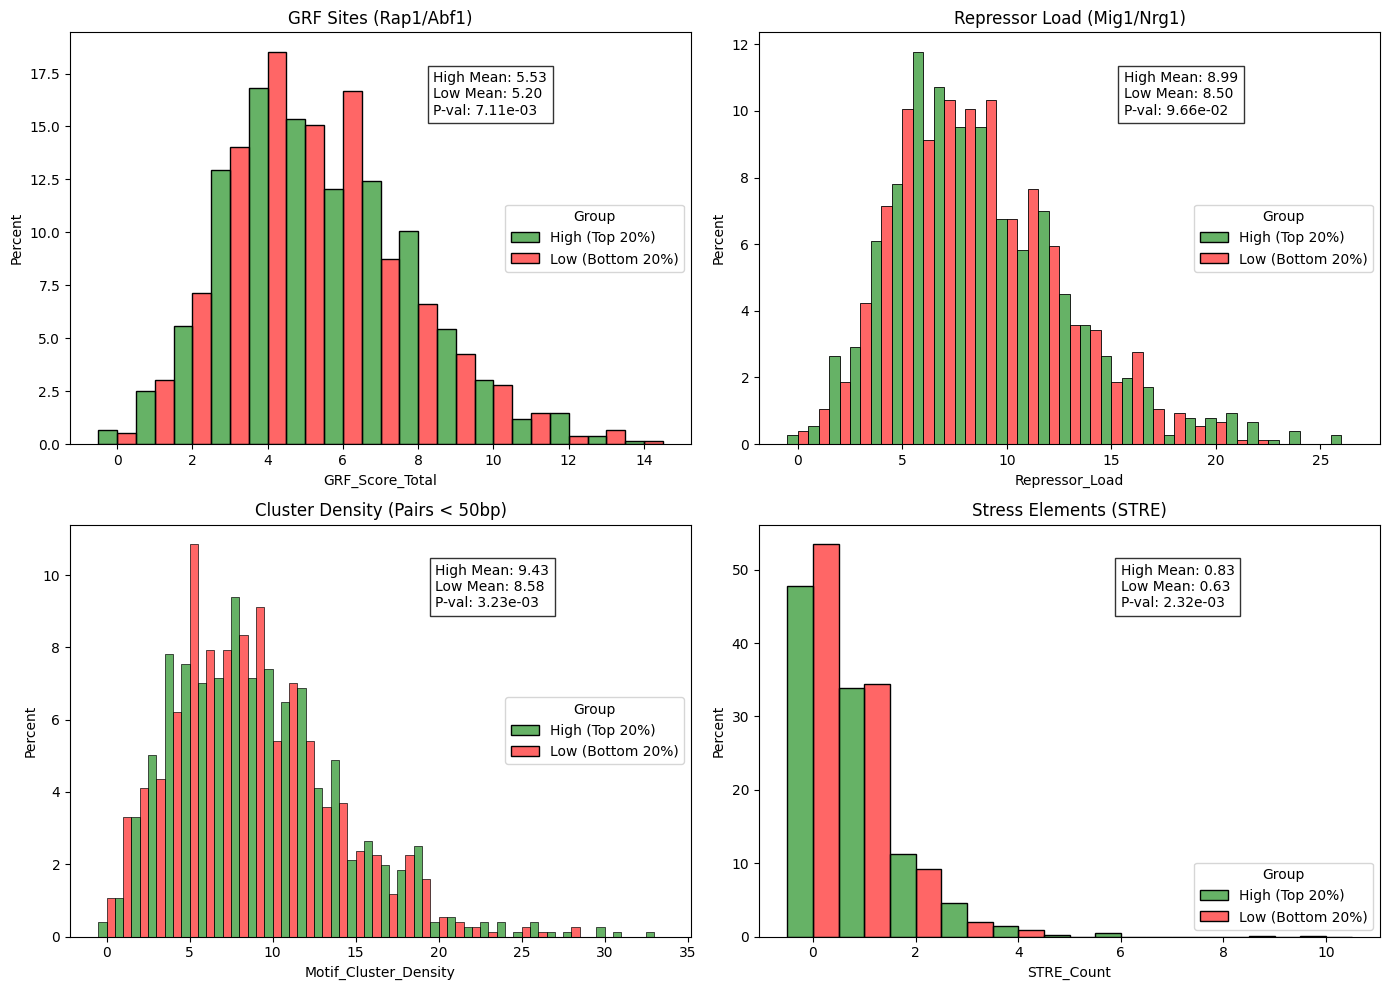


--- מסקנות מהאזור הדיסטלי ---
- GRFs (Rap1/Abf1) הם מנבאים חזקים לביטוי גבוה.
- צפיפות מוטיבים (Enhancers) תורמת לביטוי גבוה.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# ==========================================
# 1. הגדרת מטריצות (PSSM Consensus)
# ==========================================

nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': -1}

# --- GRF: Rap1 (Consensus: ACACCCATACAT) ---
# גורם אקטיבציה חזק מאוד (ריבוזומלי)
rap1_pwm = np.array([
    [1.0, 0.0, 0.0, 0.0], # A
    [0.0, 1.0, 0.0, 0.0], # C
    [1.0, 0.0, 0.0, 0.0], # A
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 1.0, 0.0, 0.0], # C
    [1.0, 0.0, 0.0, 0.0], # A
    [0.0, 0.0, 0.0, 1.0], # T
    [1.0, 0.0, 0.0, 0.0], # A
    [0.0, 1.0, 0.0, 0.0], # C
    [1.0, 0.0, 0.0, 0.0], # A
    [0.0, 0.0, 0.0, 1.0], # T
])

# --- GRF: Abf1 (Consensus: RTCRYYYYACG) ---
# מולטי-פונקציונלי, פותח כרומטין
abf1_pwm = np.array([
    [0.5, 0.0, 0.5, 0.0], # R (A/G)
    [0.0, 0.0, 0.0, 1.0], # T
    [0.0, 1.0, 0.0, 0.0], # C
    [0.5, 0.0, 0.5, 0.0], # R (A/G)
    [0.0, 0.5, 0.0, 0.5], # Y (C/T)
    [0.0, 0.5, 0.0, 0.5], # Y
    [0.0, 0.5, 0.0, 0.5], # Y
    [0.0, 0.5, 0.0, 0.5], # Y
    [1.0, 0.0, 0.0, 0.0], # A
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 0.0, 1.0, 0.0], # G
])

# --- Repressor: Mig1 (Consensus: CCCCGG) ---
# רפרסור מטבולי (גלוקוז)
mig1_pwm = np.array([
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 0.0, 1.0, 0.0], # G
    [0.0, 0.0, 1.0, 0.0], # G
])

# --- Repressor: Nrg1 (Consensus: CCCTC) ---
# רפרסור כללי
nrg1_pwm = np.array([
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 1.0, 0.0, 0.0], # C
    [0.0, 0.0, 0.0, 1.0], # T
    [0.0, 1.0, 0.0, 0.0], # C
])

# ספי זיהוי (מותאמים ל-PSSM)
# Rap1 ו-Abf1 הם מוטיבים ארוכים, הסף גבוה יותר
THRESHOLDS = {
    'Rap1': 8.0, 
    'Abf1': 6.0,
    'Mig1': 5.0,
    'Nrg1': 4.0
}

# ==========================================
# 2. פונקציות עזר (סריקה וצפיפות)
# ==========================================

def get_motif_indices(seq_numeric, pwm, threshold):
    """מחזיר רשימה של אינדקסים (מיקומים) שבהם הציון עבר את הסף"""
    motif_len = len(pwm)
    indices = []
    if len(seq_numeric) < motif_len: return []
    
    for i in range(len(seq_numeric) - motif_len + 1):
        segment = seq_numeric[i:i+motif_len]
        if -1 not in segment:
            score = sum(pwm[j, segment[j]] for j in range(motif_len))
            if score >= threshold:
                indices.append(i)
    return indices

def analyze_distal_region(row):
    full_seq = row['promoter']
    
    # חיתוך האזור הדיסטלי (-1000 עד -300)
    start_dist = -1000
    end_dist = -300
    
    # טיפול ברצפים קצרים
    if len(full_seq) < abs(end_dist):
        return pd.Series([0, 0, 0, 0], index=['GRF_Score_Total', 'Repressor_Load', 'Motif_Cluster_Density', 'STRE_Count'])
    
    # חיתוך בטוח (אם הרצף קצר מ-1000, לוקחים מההתחלה עד -300)
    actual_start = max(0, len(full_seq) - 1000)
    # ממירים לאינדקסים חיוביים
    slice_start = max(0, len(full_seq) + start_dist) 
    slice_end = len(full_seq) + end_dist
    
    distal_seq = full_seq[slice_start:slice_end]
    
    # המרה למספרים
    seq_num = [nucleotide_map.get(b, -1) for b in distal_seq]
    
    # 1. GRF Sites (Rap1 + Abf1)
    rap1_hits = get_motif_indices(seq_num, rap1_pwm, THRESHOLDS['Rap1'])
    abf1_hits = get_motif_indices(seq_num, abf1_pwm, THRESHOLDS['Abf1'])
    
    # הציון הוא סך כל ההופעות (כמות אתרי "דחפור")
    grf_total = len(rap1_hits) + len(abf1_hits)
    
    # 2. Repressor Load (Mig1 + Nrg1)
    mig1_hits = get_motif_indices(seq_num, mig1_pwm, THRESHOLDS['Mig1'])
    nrg1_hits = get_motif_indices(seq_num, nrg1_pwm, THRESHOLDS['Nrg1'])
    
    repressor_total = len(mig1_hits) + len(nrg1_hits)
    
    # 3. Motif Cluster Density
    # בודקים כמה מוטיבים קרובים אחד לשני (< 50bp)
    # מאחדים את כל ה"פיקים" לרשימה אחת ממויינת
    all_hits = sorted(rap1_hits + abf1_hits + mig1_hits + nrg1_hits)
    
    cluster_pairs = 0
    if len(all_hits) > 1:
        for i in range(len(all_hits) - 1):
            dist = all_hits[i+1] - all_hits[i]
            if dist < 50: # אם המרחק קטן מ-50 בסיסים
                cluster_pairs += 1
                
    # 4. STRE Count (Stress Response Elements)
    # ספירת המחרוזת CCCCT והמשלים AGGGG
    stre_count = distal_seq.count('CCCCT') + distal_seq.count('AGGGG')
    
    return pd.Series({
        'GRF_Score_Total': grf_total,
        'Repressor_Load': repressor_total,
        'Motif_Cluster_Density': cluster_pairs,
        'STRE_Count': stre_count
    })

# ==========================================
# 3. ניהול הרצה וגרפים
# ==========================================

def run_distal_analysis(csv_path):
    # שם קובץ דינמי
    base_name = os.path.splitext(os.path.basename(csv_path))[0]
    output_csv = f"distal_analysis_{base_name}.csv"
    
    print(f"--- מעבד אזור דיסטלי (-1000 עד -300) לקובץ: {csv_path} ---")
    try:
        df = pd.read_csv(csv_path)
        if 'promoter' not in df.columns:
             df.columns = ['promoter', 'mrna_level'] + list(df.columns[2:])
    except:
        print("שגיאה בטעינת הקובץ.")
        return None

    # חילוץ הפיצ'רים
    distal_features = df.apply(analyze_distal_region, axis=1)
    final_df = df.join(distal_features)
    
    # חישוב אחוזונים
    final_df['expression_percentile'] = final_df['mrna_level'].rank(pct=True) * 100
    
    # שמירה
    final_df.to_csv(output_csv, index=False)
    print(f"✅ נתונים נשמרו לקובץ: {output_csv}")
    
    # הפקת גרפים
    plot_distal_stats(final_df)
    
    return final_df

def plot_distal_stats(df):
    print("\n=== השוואה: Top 20% vs Bottom 20% (Distal Region) ===")
    
    high_group = df[df['expression_percentile'] >= 80].copy()
    low_group = df[df['expression_percentile'] <= 20].copy()
    
    # איזון
    min_size = min(len(high_group), len(low_group))
    high_bal = high_group.sample(n=min_size, random_state=42)
    low_bal = low_group.sample(n=min_size, random_state=42)
    
    high_bal['Group'] = 'High (Top 20%)'
    low_bal['Group'] = 'Low (Bottom 20%)'
    combined = pd.concat([high_bal, low_bal])
    
    # רשימת הפיצ'רים לגרפים
    features = [
        ('GRF_Score_Total', 'GRF Sites (Rap1/Abf1)'),
        ('Repressor_Load', 'Repressor Load (Mig1/Nrg1)'),
        ('Motif_Cluster_Density', 'Cluster Density (Pairs < 50bp)'),
        ('STRE_Count', 'Stress Elements (STRE)')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    conclusions = []
    
    for i, (col, title) in enumerate(features):
        ax = axes[i]
        
        # היסטוגרמה בדידה (כי אלו ספירות של מס' מוטיבים)
        sns.histplot(data=combined, x=col, hue='Group', 
                     stat="percent", common_norm=False, multiple="dodge",
                     palette={'High (Top 20%)': 'green', 'Low (Bottom 20%)': 'red'}, 
                     ax=ax, discrete=True, alpha=0.6)
        
        ax.set_title(title)
        
        # סטטיסטיקה
        mean_high = high_bal[col].mean()
        mean_low = low_bal[col].mean()
        stat, p_val = stats.mannwhitneyu(high_bal[col], low_bal[col])
        
        stats_text = (f"High Mean: {mean_high:.2f}\n"
                      f"Low Mean: {mean_low:.2f}\n"
                      f"P-val: {p_val:.2e}")
        
        y_lim = ax.get_ylim()[1]
        x_max = max(combined[col].max(), 1) # למנוע קריסה אם הכל 0
        
        ax.text(x_max*0.6, y_lim*0.80, stats_text, 
                bbox=dict(facecolor='white', alpha=0.8))

        # הסקת מסקנות אוטומטית
        if p_val < 0.05:
            if col == 'GRF_Score_Total' and mean_high > mean_low:
                conclusions.append("GRFs (Rap1/Abf1) הם מנבאים חזקים לביטוי גבוה.")
            elif col == 'Repressor_Load' and mean_low > mean_high:
                conclusions.append("עומס רפרסורים נמצא בקורלציה לביטוי נמוך (כצפוי).")
            elif col == 'Motif_Cluster_Density' and mean_high > mean_low:
                conclusions.append("צפיפות מוטיבים (Enhancers) תורמת לביטוי גבוה.")
    
    plt.tight_layout()
    plt.show()
    
    print("\n--- מסקנות מהאזור הדיסטלי ---")
    if not conclusions:
        print("לא נמצאו הבדלים מובהקים בפיצ'רים שנבדקו.")
    for c in conclusions:
        print(f"- {c}")

# ==========================================
# הפעלה
# ==========================================
df_distal = run_distal_analysis('train1.csv')

--- מעבד אזור דיסטלי (-1000 עד -300) לקובץ: train2.csv ---
✅ נתונים נשמרו לקובץ: distal_analysis_train2.csv

=== השוואה: Top 20% vs Bottom 20% (Distal Region) ===


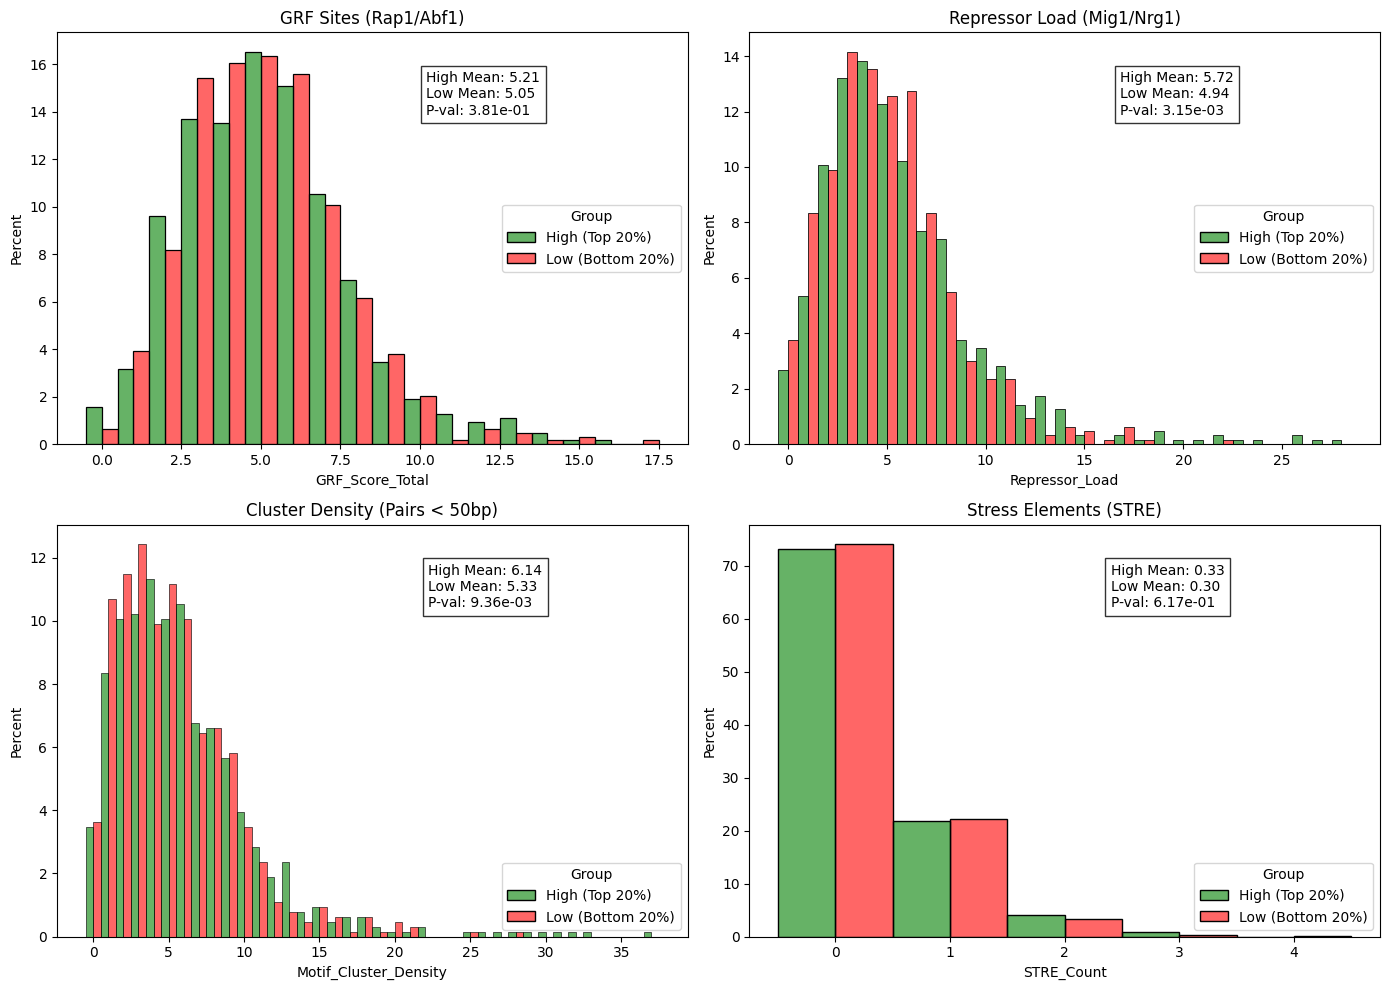


--- מסקנות מהאזור הדיסטלי ---
- צפיפות מוטיבים (Enhancers) תורמת לביטוי גבוה.


In [3]:
df_distal = run_distal_analysis('train2.csv')